Member 1 : Load,Feature assembly +Extra SVM model training ~mariam

Member 2: Preprocessing

Member 3: Color & GLCM ~mirna

Member 4:LBP & HOG ~lara

Member 5:Medical Features ~nour

Member 6:Scaling & LR

Member 7:Kmeans & Result Visuals ~ganna

# **IMAGE LOAD & EXPLOARATION**

Auto-detect disease classes from folder structure

Count images per class

Calculate dataset statistics

Display sample images per disease

Create class-to-index mapping (lw fe haga zyada zwdoha)

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import cv2
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc, silhouette_score
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Loading the dataset

In [2]:
import os  # تأكد من وجود هذا السطر

# ---------------------------------------------------------
# الجزء الخاص بـ Google Colab (تم تعطيله لأنه لا يعمل محلياً)
# ---------------------------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
# print("✓ Google Drive mounted!")

# ---------------------------------------------------------
# تحديد مسار البيانات (Data Path)
# ---------------------------------------------------------

# Option A: Google Drive (لا تستخدمه الآن)
DATA_PATH = '/content/gdrive/My Drive/eye_disease'

# Option B: Colab uploaded folder (لا تستخدمه الآن)
# DATA_PATH = '/content/eye_disease_data/'

# Option C: Local machine (هذا هو الخيار الصحيح لك)
# تأكد أن مجلد البيانات موجود بجانب ملف الكود أو ضع المسار الكامل
#DATA_PATH = r'C:\TERM5\eye_disease-20251210T161904Z-3-001\eye_disease'
# أو إذا كان المجلد بجانب السكربت مباشرة استخدم: './data/eye_disease_data/'

print(f"📁 Data path set to: {DATA_PATH}")
print(f"📁 Checking if path exists...")

if os.path.exists(DATA_PATH):
    print(f"Path found!")
    # طباعة أول 5 ملفات فقط للتأكد دون ملء الشاشة
    print(f"Contents (first 5): {os.listdir(DATA_PATH)[:5]}")
else:
    print(f"❌ Path NOT found! Check DATA_PATH")
    print(f"Current working directory is: {os.getcwd()}") # لتعرف أين يبحث بايثون

Mounted at /content/gdrive
📁 Data path set to: /content/gdrive/My Drive/eye_disease
📁 Checking if path exists...
Path found!
Contents (first 5): ['glaucoma', 'cataract', 'diabetic_retinopathy', 'normal']


Exploration and imbalance detection

In [3]:
def explore_dataset(data_path):
    class_counts = {}
    # Iterate through subdirectories
    for item in os.listdir(data_path):
        item_path = os.path.join(data_path, item)
        if not os.path.isdir(item_path):
            continue
        image_files = [f for f in os.listdir(item_path)
                      if f.lower().endswith(('.jpg', '.png', '.jpeg'))] # Count image files (.jpg, .png, .jpeg)
        if len(image_files) > 0: # Only include directories with images
            class_counts[item] = len(image_files)
            print(f"Found class '{item}': {len(image_files)} images")
        else:
            print(f"Folder '{item}' has no images (skipped)")
    class_names = sorted(class_counts.keys()) # Sort class names alphabetically
    return class_counts, class_names
class_counts, class_names = explore_dataset(DATA_PATH)
# Display results
print(f"\n Dataset detected")
print(f"  Total classes: {len(class_names)}")
print(f"  Classes: {class_names}")
total_images = sum(class_counts.values())
print(f"\n  Class distribution:")
for cls in class_names:
    count = class_counts[cls]
    pct = (count / total_images) * 100
    print(f"    - {cls:25s}: {count:4d} images ({pct:5.1f}%)")
print(f"\n     Total images: {total_images}")

Found class 'glaucoma': 1007 images
Found class 'cataract': 1038 images
Found class 'diabetic_retinopathy': 1098 images
Found class 'normal': 1074 images

 Dataset detected
  Total classes: 4
  Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

  Class distribution:
    - cataract                 : 1038 images ( 24.6%)
    - diabetic_retinopathy     : 1098 images ( 26.0%)
    - glaucoma                 : 1007 images ( 23.9%)
    - normal                   : 1074 images ( 25.5%)

     Total images: 4217


Classes mapping to indices  

In [4]:
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
idx_to_class = {idx: cls for idx, cls in enumerate(class_names)}
for cls, idx in sorted(class_to_idx.items()):
    print(f"  {idx} → {cls}")

  0 → cataract
  1 → diabetic_retinopathy
  2 → glaucoma
  3 → normal


Loading Images

In [5]:
def load_image(image_path):
    img = cv2.imread(image_path)  # Load image 'its loaded as numpy array'
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    return img
sample_images = {}#storing sample images per class
errors = 0 #error flag ehtyate
for class_name in class_names:
    class_path = os.path.join(DATA_PATH, class_name)
    image_files = [f for f in os.listdir(class_path)
                  if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    sample_images[class_name] = [] # Load first 3 images from this class
    for i, img_file in enumerate(image_files[:3]):
        img_path = os.path.join(class_path, img_file)
        img = load_image(img_path)
        if img is not None:
            sample_images[class_name].append((img, img_file))
        else:
            errors += 1
    print(f"Loaded {len(sample_images[class_name])} samples from {class_name}")
print(f"\nSample loading complete ({errors} errors)")

Loaded 3 samples from cataract
Loaded 3 samples from diabetic_retinopathy
Loaded 3 samples from glaucoma
Loaded 3 samples from normal

Sample loading complete (0 errors)


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
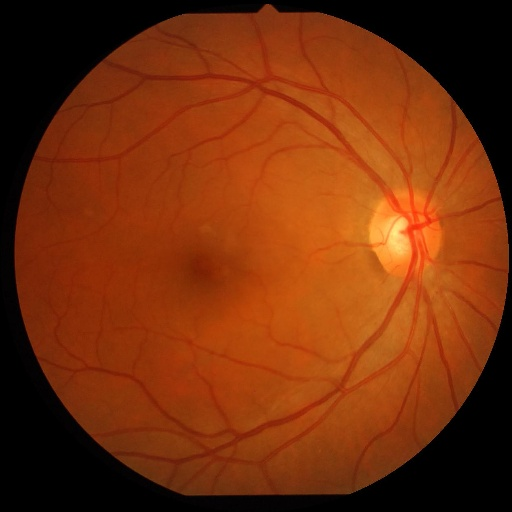

In [6]:
img #testing akher wahda et7t fl variable

 Sample images grid saved: 01_sample_images.png


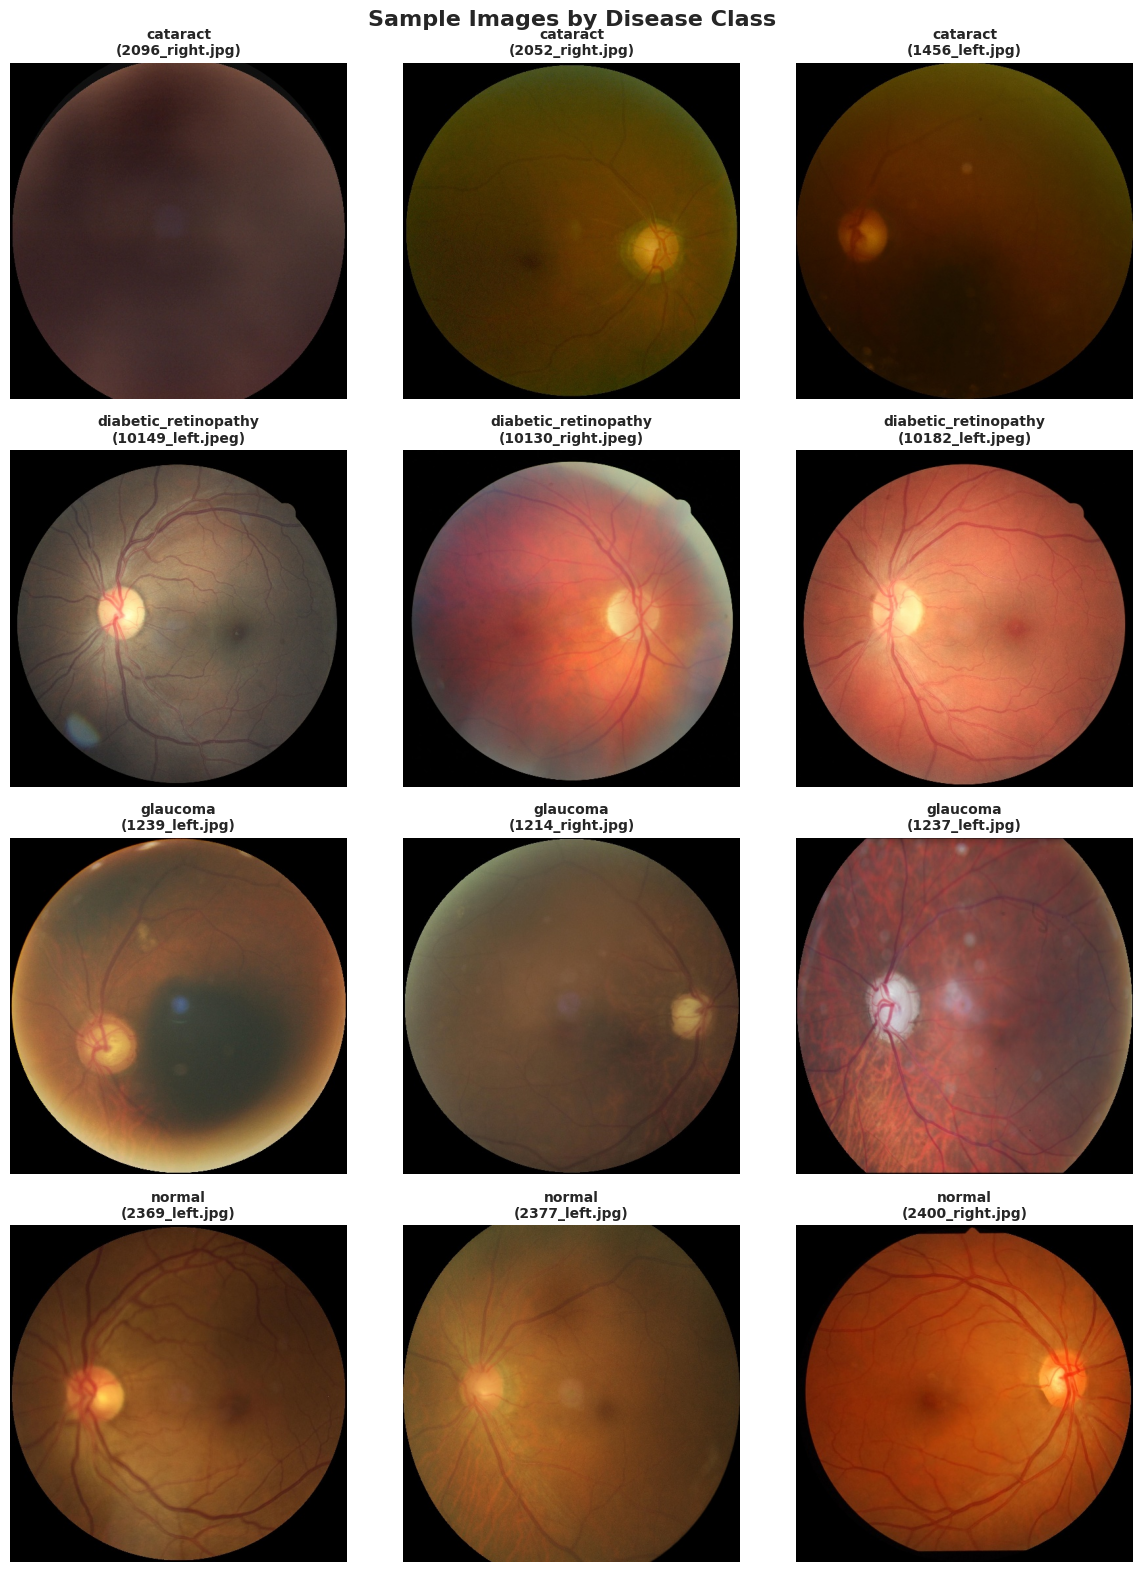

In [7]:
n_classes = len(class_names)# Create grid of sample images (3 per class)
fig, axes = plt.subplots(n_classes, 3, figsize=(12, 4 * n_classes))
if n_classes == 1:
    axes = axes.reshape(1, -1)
fig.suptitle("Sample Images by Disease Class", fontsize=16, fontweight='bold')
for row, class_name in enumerate(class_names): #fetching the image with its title w kda
    samples = sample_images[class_name]
    for col in range(3): #3yzen only 3 cols = 3 samples each ya3ne
        ax = axes[row, col]
        if col < len(samples):
            img, filename = samples[col]
            ax.imshow(img)
            ax.set_title(f"{class_name}\n({filename})", fontsize=10, fontweight='bold')
        ax.axis('off')#no grid lines fl swar
plt.tight_layout()
print(" Sample images grid saved: 01_sample_images.png")
plt.show()

In [8]:
# Create statistics DataFrame
stats_data = []
for cls in class_names:
    count = class_counts[cls]
    pct = (count / total_images) * 100
    stats_data.append({
        'Disease Class': cls,
        'Image Count': count,
        'Percentage': f"{pct:.1f}%"
    })
stats_df = pd.DataFrame(stats_data)
print(f"\n{'Total Images:':<25} {total_images:>6d}")
print(f"{'Number of Classes:':<25} {len(class_names):>6d}")
print(f"{'Min class size:':<25} {min(class_counts.values()):>6d}")
print(f"{'Max class size:':<25} {max(class_counts.values()):>6d}")
print(f"{'Mean class size:':<25} {np.mean(list(class_counts.values())):>6.1f}")



Total Images:               4217
Number of Classes:             4
Min class size:             1007
Max class size:             1098
Mean class size:          1054.2


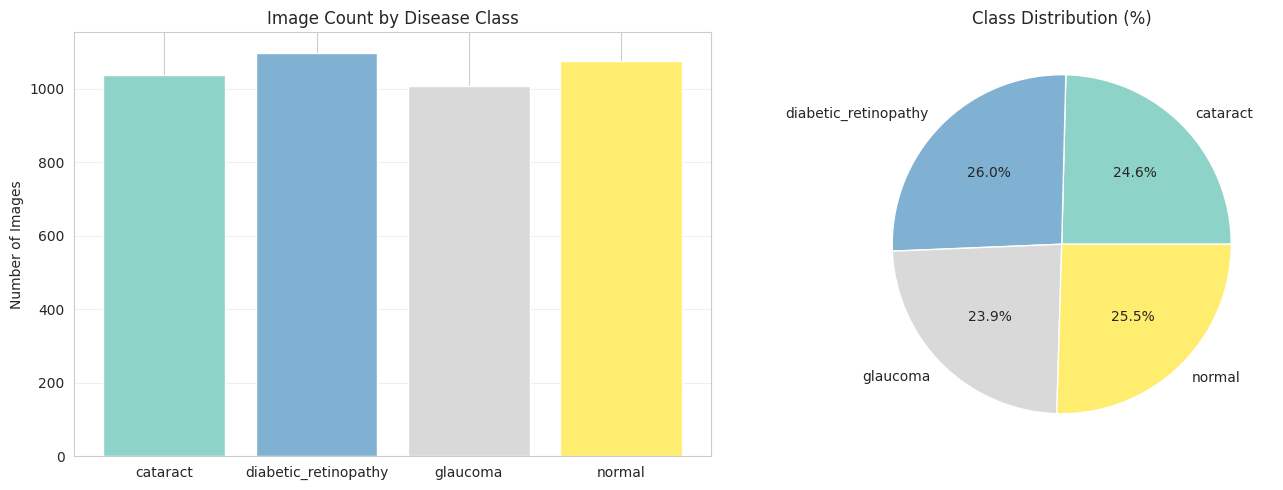

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# Colors
colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
#Bar Chart
counts = [class_counts[c] for c in class_names]
ax1.bar(class_names, counts, color=colors)
ax1.set_title("Image Count by Disease Class")
ax1.set_ylabel("Number of Images")
ax1.grid(axis='y', alpha=0.3)
#Pie Chart
percentages = [count / total_images * 100 for count in counts]
ax2.pie(percentages, labels=class_names, autopct='%1.1f%%', colors=colors)
ax2.set_title("Class Distribution (%)")
plt.tight_layout()
plt.show()

###After Code Explaination

Understand data balance/imbalance

Identify missing data or corrupted files

Set expectations for model performance

Visual intuition helps feature engineering

DATA IS BALANCED

BASELINE MODEL PREFORMANCE 70-80 LR

SVM 90+ INSHA2ALLAH



---



# **Resize & Normalization**

Load each image from disk

Convert color space (BGR → RGB if using OpenCV)

Resize to standard dimensions (e.g., 256×256)

Normalize pixel values (0-255 → 0-1)

Handle errors (corrupted files, missing images)

In [10]:
# DRAFT #Do not run
# X is images
# y is labels/classes
X = []
y = []
for class_name in class_names:
    class_path = os.path.join(DATA_PATH, class_name)
    image_files = [f for f in os.listdir(class_path)
                  if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(class_path, img_file)
        img = load_image(img_path)
        # We convert it to gray or not?
        if img is not None:
            img = cv2.resize(img, (224, 224))
            img = img /255.0
            # 1D instead of 3D + Normaliztion
            # default dtype is float64
            X.append(img)
            y.append(class_name)

X = np.array(X, dtype='float32')
y = np.array(y)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0, stratify=y_encoded)
# stratify=y forces the split to respect the class percentages

### After Code Explaination

Fixed input size: Traditional ML models need fixed-dimension vectors

Faster processing: Smaller images = faster feature extraction

Consistent scaling: Normalized values help optimization algorithms



---



# **Feature extraction**

3.1 Color Features (96 dimensions)
What: Color distribution of the fundus

Why: Different diseases have different color signatures

Normal: Reddish, healthy color

Diabetic Retinopathy: Dark red spots (blood leakage)

Glaucoma: Pale optic disc

Cataract: Whitish, cloudy

Method: HSV Histograms

Convert image to HSV (better than RGB for diseases)

Create histogram for each channel: Hue, Saturation, Value

32 bins per channel → 32 × 3 = 96 features

Normalize histogram (sum = 1)

ColorHistogram(): captures COLOR information

Diabetic Retinopathy : red dots

Glaucoma : pale/yellowish optic disc

Age-related macular degeneration : yellow drusen spots

Retinitis pigmentosa : dark pigment clumping

.........................................................................

Hue = what color the lesion is

Saturation = how intense it is

Value = how bright/dark the region is

In [11]:
def ColorHistogram(image, h_bins=32, s_bins=32, v_bins=32, normalize=True):

    # Ensure input is uint8 0..255 because OpenCV/HSV expects that.
    img_uint8 = (np.clip(image, 0.0, 1.0) * 255.0).astype(np.uint8)

    # OpenCV expects images in BGR by default; we have RGB -> convert to BGR first
    img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)

    # Convert to HSV color space (H: 0-179, S:0-255, V:0-255 )
    # HSV is better for medical analysis.
    # H -> hue (color type (red, green, blue))
    # S -> saturation (color intensity (pale to vivid))
    # V -> value (brightness)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # Compute per-channel histograms
    # images: [hsv] input image
    # channels: [0], [1], [2] ( H, S, V )
    # mask: None , use the whole image (no masking)
    # histSize: number of bins for each channel
    # ranges: value range for each channel
    # Flatten histograms to 1D arrays for concatenation
    hist_h = cv2.calcHist([hsv], [0], None, [h_bins], [0, 180]).flatten()
    hist_s = cv2.calcHist([hsv], [1], None, [s_bins], [0, 256]).flatten()
    hist_v = cv2.calcHist([hsv], [2], None, [v_bins], [0, 256]).flatten()

    # Normalize histograms to sum to 1
    # This ensures features represent percentages, not absolute counts
    if normalize:
        # small constant to avoid division by zero in completely blank images
        eps = 1e-8
        hist_h = hist_h / (hist_h.sum() + eps)
        hist_s = hist_s / (hist_s.sum() + eps)
        hist_v = hist_v / (hist_v.sum() + eps)

    # Concatenate to form final color feature vector
    color_feature = np.concatenate([hist_h, hist_s, hist_v]).astype(np.float32)
    # Use float32 to save memory and make the numbers keep their accuracy without rounding too much, so small differences in feature values are preserved.

    # With 32 bins per channel:
    # H = 32 values, S = 32 values, V = 32 values → total = 96 features (shape: (96,))

    return color_feature

3.2 GLCM Texture Features (4 dimensions)
What: Gray Level Co-occurrence Matrix (texture properties)

Why: Disease-specific texture patterns

Normal: Smooth, uniform texture

DR: Rough, irregular (microaneurysms)

Glaucoma: Gradual changes

Cataract: Dense patterns

Method:

Convert to grayscale

Compute GLCM (pixel co-occurrence at distance 1 pixel)

Extract 4 statistics:

Contrast: How different are adjacent pixels? (high = rough)

Homogeneity: How uniform is texture? (high = smooth)

Energy: How ordered is pattern? (high = regular)

Correlation: Pixel dependency (high = related to neighbors)

Code outline:

GLCM(): captures TEXTURE information

Diabetic Retinopathy creates fine-grain textures (microaneurysms, exudates)

Glaucoma changes nerve fiber layer texture

Macular degeneration creates rough / uneven patterns

Edema creates smooth-to-rough transitions

.........................................................................

GLCM extracts statistical texture relationships such as:

contrast (edge strength)

homogeneity (smoothness)

correlation (structure consistency)

energy / ASM (pattern repetition)

In [12]:
def extract_glcm_features(image):

    # Convert float image (0..1) to uint8 (0..255)
    # Convert RGB to grayscale (GLCM works on single-channel images)
    # each pixel will have a single value( 0 for white , 255 for black and the mid values are greys)
    #instead of three(for blue , red and green )
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Default GLCM parameters
    distances = [1]                            # pixel distance (take th exact neighboor)
    angles = [0]  # directions: 0°, 45°, 90°, 135° (calculate for all directions)
    levels = 256                               # gray levels (8-bit image)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']

    # contrast: measures the intensity difference between neighboring pixels (high for edges/noisy areas)
    # dissimilarity: similar to contrast but grows more gently with large intensity differences
    # homogeneity: measures how similar neighboring pixels are (higher when the texture is smooth)
    # energy: measures uniformity and repetition in the texture
    # correlation: measures how strongly pixel intensities are linearly related across pairs
    # ASM (Angular Second Moment): another measure of uniformity, closely related to energy

    # Compute the Gray-Level Co-occurrence Matrix (GLCM)
    # symmetric [i,j] = [j,i]
    # normed (normalized) , features represent percentages not absolute values
    glcm = graycomatrix(gray, distances=distances, angles=angles, levels=levels,
                        symmetric=True, normed=True)

    # GLCM matrix generated by graycomatrix has the shape of (levels, levels, num_distances, num_angles)
    # row dimension of each GLCM , col dimension of each GLCM , number of distances , number of angles


    feats = []
    # Loop over each distance and angle to extract all requested properties
    # for distance in range(glcm.shape[2]):                     # distances dimension
    #     for angle in range(glcm.shape[3]):                    # angles dimension
    for p in props:                                   # iterate over requested texture properties
                val = graycoprops(glcm, p)[0, 0]   # extract property value
                feats.append(float(val))                      # append to feature list


    # Example output: array of 24 features (1 distance × 4 angles × 6 properties)
    # [3.12, 1.45, 0.88, 0.20, 0.93, 0.001,  ...  0.92]

    return np.array(feats, dtype=np.float32)
    # Use float32 to save memory and make the numbers keep their accuracy without rounding too much, so small differences in feature values are preserved.


3.3 LBP Texture Features (59 dimensions)
What: Local Binary Patterns (micro-texture)

Why: Captures fine details that differ by disease

Method:

Convert to grayscale

For each pixel, compare to 8 neighbors

Create binary code (256 possibilities)

Use "uniform" LBP (only 59 valid patterns, ignore noise)

Build histogram of pattern frequencies

In [13]:
def extract_lbp_features(img):
    P=8 #8 neighbours
    r=1#radius of the circle is 1(pixels)
    method= 'uniform'
    img_for_lbp=(img*255).astype(np.uint8)
    #bc i need img to be 0..255 (not as it is rn normalized 0..1)
    #and uint8 bc lbp expects integer values, and the default dtype of img is float
    grayimg = cv2.cvtColor(img_for_lbp, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(grayimg, P, r, method)
    #lbp is gonna store a 2d arr with pixel,lbp pattern
    hist, _ = np.histogram(lbp, bins=59, range=(0,59))
    hist = hist.astype('float')
    hist/=hist.sum()
    return hist

3.4 HOG Features (180 dimensions)
What: Histogram of Oriented Gradients (edge direction & strength)

Why: Captures shape and structure

Vessels have directional patterns

Optic disc is circular (specific gradients)

Lesions have irregular edges

Method:

Convert to grayscale

Compute image gradients (edge detection)

Divide image into cells (8×8 pixels each)

For each cell, create histogram of gradient directions (9 bins)

Normalize by overlapping blocks (2×2 cells)

Flatten to 1D vector (~180 values)

In [14]:
def extract_hog_features(img):
    img_for_hog = (img * 255).astype(np.uint8)
    grayimg = cv2.cvtColor(img_for_hog, cv2.COLOR_BGR2GRAY)
    hog_desc = hog(grayimg, orientations=9, pixels_per_cell=(8,8),cells_per_block=(2,2),block_norm='L2-Hys',visualize=False, channel_axis=None)
    return hog_desc

3.5 Structural Features (3 dimensions)
What: Medical domain features (vessels, optic disc, lesions)

Why: Encodes anatomical knowledge

Feature 1: Vessel Density

Detect dark pixels (blood vessels)

Threshold + morphological ops

Ratio: vessel_pixels / total_pixels

Normal: ~0.2-0.3 | DR: reduced | Glaucoma: compressed

Feature 2: Optic Disc Size

Detect bright pixels (yellowish disc)

Find largest bright region

Ratio: disc_area / total_area

Normal: ~0.10-0.15 | Glaucoma: reduced cupping

Feature 3: Lesion Count (proxy)

Detect red spots (R channel - G channel difference)

Threshold for abnormal regions

Ratio: lesion_pixels / total_pixels

Normal: 0.0 | DR: 0.05-0.30 (increasing with severity)

Feature 1: Vessel Density

In [15]:
def get_vessel_density(image):
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    _, vessels_binary = cv2.threshold(gray, 50, 1, cv2.THRESH_BINARY_INV)
    vessel_density = vessels_binary.sum() / (gray.shape[0] * gray.shape[1])
    return vessel_density

Feature 2: Optic Disc Size

In [16]:
def get_disc_area(image):
    hsv = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    v_channel = hsv[:, :, 2]
    disc_threshold = v_channel.mean() + v_channel.std()
    disc_binary = (v_channel > disc_threshold).astype(int)
    disc_area = disc_binary.sum() / (v_channel.shape[0] * v_channel.shape[1])
    return disc_area

Feature 3: Lesion Count (proxy)

In [17]:
def get_lesion_count(image):
    image_uint8 = (image * 255).astype(np.uint8)
    r_channel = image_uint8[:, :, 0].astype(float)
    g_channel = image_uint8[:, :, 1].astype(float)
    lesion_map = np.maximum(0, (r_channel - g_channel) / 255.0)
    lesion_count = (lesion_map > 0.3).sum() / (lesion_map.shape[0] * lesion_map.shape[1])
    return lesion_count

Combine all 3  Structural Features

In [18]:
def extract_structural_features(image):
    vd = get_vessel_density(image)
    disc = get_disc_area(image)
    lesion = get_lesion_count(image)
    return np.array([vd, disc, lesion])

3.6 Combine All Features
Result: 342-dimensional feature vector per image

Function to extract feature vector for each image:

In [19]:
def all_features_vector(img):
  return np.concatenate([
      ColorHistogram(img),
      extract_glcm_features(img),
      extract_lbp_features(img),
      extract_hog_features(img),
      extract_structural_features(img)
  ])

Function to extract features for all images in the dataset:

Extracting Features:

In [20]:
def extractFeatures_Batched_fromImages(images, labels, batch_size=64, resize_to=224):
    """Extract features from already-split image arrays"""
    import gc
    features_list = []

    print(f"Extracting features from {len(images)} images...")

    for batch_start in range(0, len(images), batch_size):
        batch_images = images[batch_start:batch_start + batch_size]
        batch_features = []

        for img in batch_images:
            try:
                # Preprocess
                if img.dtype != np.uint8:
                    img = (img * 255).astype(np.uint8)

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (resize_to, resize_to))
                img = img / 255.0

                # Extract features
                features = all_features_vector(img)
                batch_features.append(features)
            except Exception as e:
                print(f"⚠️ Error: {e}")
                continue

        features_list.extend(batch_features)
        batch_features.clear()
        gc.collect()
        print(f"  ✓ {len(features_list)} features extracted")

    X = np.array(features_list, dtype=np.float32)
    y = np.array(labels)
    return X, y

# Now use it:
Xtrain_features, ytrain = extractFeatures_Batched_fromImages(X_train, y_train,
                                                             batch_size=64,
                                                             resize_to=224)
Xtest_features, ytest = extractFeatures_Batched_fromImages(X_test, y_test,
                                                           batch_size=64,
                                                           resize_to=224)

Extracting features from 3373 images...
  ✓ 64 features extracted
  ✓ 128 features extracted
  ✓ 192 features extracted
  ✓ 256 features extracted
  ✓ 320 features extracted
  ✓ 384 features extracted
  ✓ 448 features extracted
  ✓ 512 features extracted
  ✓ 576 features extracted
  ✓ 640 features extracted
  ✓ 704 features extracted
  ✓ 768 features extracted
  ✓ 832 features extracted
  ✓ 896 features extracted
  ✓ 960 features extracted
  ✓ 1024 features extracted
  ✓ 1088 features extracted
  ✓ 1152 features extracted
  ✓ 1216 features extracted
  ✓ 1280 features extracted
  ✓ 1344 features extracted
  ✓ 1408 features extracted
  ✓ 1472 features extracted
  ✓ 1536 features extracted
  ✓ 1600 features extracted
  ✓ 1664 features extracted
  ✓ 1728 features extracted
  ✓ 1792 features extracted
  ✓ 1856 features extracted
  ✓ 1920 features extracted
  ✓ 1984 features extracted
  ✓ 2048 features extracted
  ✓ 2112 features extracted
  ✓ 2176 features extracted
  ✓ 2240 features extrac



---



# **Traditional ML+Evaluation**

What happens:

Scale features using StandardScaler

Fit on training data ONLY

Apply to all sets

Result: mean ≈ 0, std ≈ 1

Train Logistic Regression

Linear classification model

Multi-class (4 diseases)

Hyperparameter C (regularization)

Evaluate on test set

Accuracy

Precision, Recall, F1-score

Confusion matrix

ROC-AUC per class

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
import matplotlib.pyplot as plt
import warnings


In [22]:
def train_and_test(X_train, y_train, X_test, y_test, name):
    print(f"\n--- Running: {name} ---")

    # Using standard Logistic Regression
    model = LogisticRegression(max_iter=1000, random_state= 1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"Accuracy: {acc * 100:.2f}%")
    print(classification_report(y_test, y_pred, target_names=class_names))

    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

In [23]:
# We will test 3 different scaling methods (Standard, MinMax, Robust)
# to see which one makes the Logistic Regression perform best.

Running Experiment 1...

--- Running: StandardScaler ---
Accuracy: 86.49%
                      precision    recall  f1-score   support

            cataract       0.87      0.81      0.84       208
diabetic_retinopathy       0.99      1.00      1.00       220
            glaucoma       0.80      0.73      0.76       201
              normal       0.80      0.91      0.85       215

            accuracy                           0.86       844
           macro avg       0.86      0.86      0.86       844
        weighted avg       0.87      0.86      0.86       844



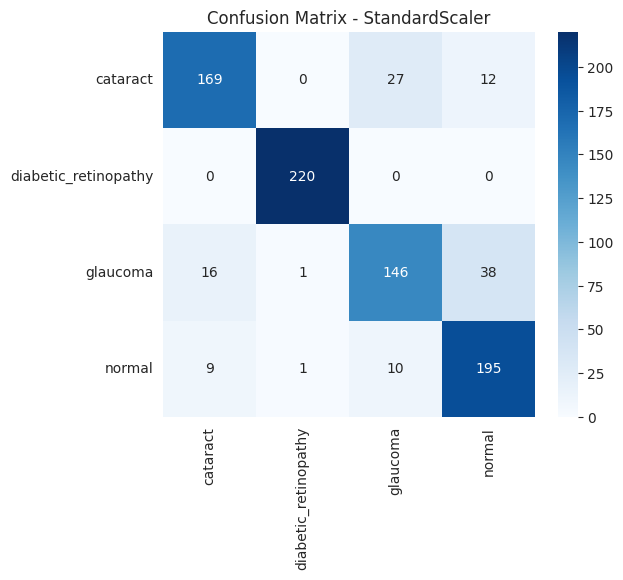

In [24]:
from sklearn.preprocessing import StandardScaler

# Experiment 1: Using StandardScaler
# Why: This centers the data (Mean=0, Std=1).
# It is the preferred scaling for PCA and Logistic Regression to work correctly.
print("Running Experiment 1...")

# 1. Scale the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(Xtrain_features)
X_test_std = scaler.transform(Xtest_features)

# 2. Train and show results
train_and_test(X_train_std, y_train, X_test_std, y_test, "StandardScaler")


Running Experiment 2...

--- Running: MinMaxScaler ---
Accuracy: 85.90%
                      precision    recall  f1-score   support

            cataract       0.83      0.82      0.83       208
diabetic_retinopathy       0.99      1.00      0.99       220
            glaucoma       0.80      0.71      0.75       201
              normal       0.80      0.90      0.85       215

            accuracy                           0.86       844
           macro avg       0.86      0.86      0.85       844
        weighted avg       0.86      0.86      0.86       844



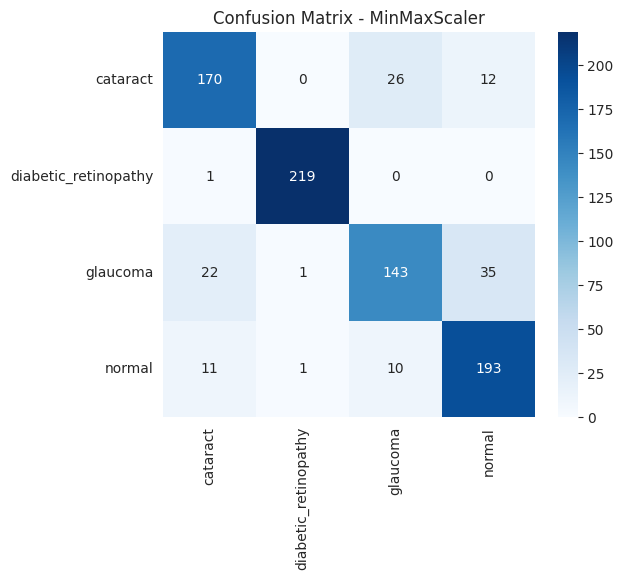

In [25]:
from sklearn.preprocessing import MinMaxScaler

# Experiment 2: Using MinMaxScaler
# Why: This squeezes all values between 0 and 1.
# We test it to see if strictly bounded data improves the model's convergence.
print("\nRunning Experiment 2...")

# 1. Scale the features (Normalization)
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(Xtrain_features)
X_test_norm = scaler.transform(Xtest_features)

# 2. Train and show results
train_and_test(X_train_norm, y_train, X_test_norm, y_test, "MinMaxScaler")


Running Experiment 3...

--- Running: RobustScaler ---
Accuracy: 84.60%
                      precision    recall  f1-score   support

            cataract       0.81      0.80      0.81       208
diabetic_retinopathy       0.99      1.00      0.99       220
            glaucoma       0.77      0.67      0.71       201
              normal       0.80      0.90      0.84       215

            accuracy                           0.85       844
           macro avg       0.84      0.84      0.84       844
        weighted avg       0.84      0.85      0.84       844



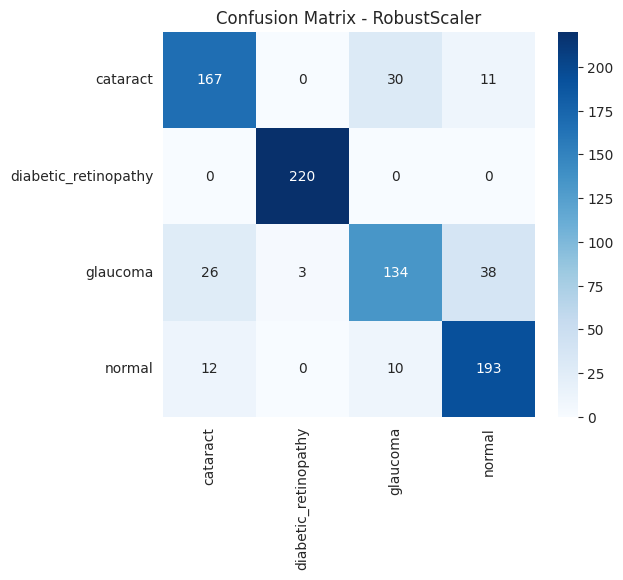

In [26]:
from sklearn.preprocessing import RobustScaler

# Experiment 3: Using RobustScaler
# Why: This scaler ignores extreme values (Outliers).
# We test it just in case our medical images contain noise/errors that confuse the other scalers.
print("\nRunning Experiment 3...")

# 1. Scale the features (Good for handling outliers)
scaler = RobustScaler()
X_train_robust = scaler.fit_transform(Xtrain_features)
X_test_robust = scaler.transform(Xtest_features)

# 2. Train and show results
train_and_test(X_train_robust, y_train, X_test_robust, y_test, "RobustScaler")

In [27]:
# Decision: We choose StandardScaler (X_train_std) for the next steps.
# Why?
# 1. Even though MinMaxScaler gave slightly higher accuracy, StandardScaler is
#    mathematically required for PCA to work correctly (it needs Mean=0).
# 2. It provides the most statistically "stable" distribution for our features.

In [28]:
X_train_final, X_test_final = X_train_std, X_test_std
print(f"Shape: {X_train_final.shape}")

Shape: (3373, 26408)


In [29]:
# Why PCA?
# 1. Our feature extraction (especially HOG on 256x256 images) produced
#    a massive feature vector (34,778 features!).
# 2. This is huge compared to our dataset size (~3,300 images), creating
#    the "Curse of Dimensionality" (Risk of Overfitting + Slow training).
# 3. PCA is essential here to reduce this noise while keeping 98% of the signal.
#
# 4. Speed & Efficiency: Processing 34,000 columns for every image is very slow.
#    PCA drastically speeds up training by reducing calculations (approx 10x faster).

In [30]:
print("\n-Dimensionality Reduction (PCA) ")

print(f"Original Feature Count: {X_train_final.shape[1]}")

# 1. Initialize PCA
# We chose 98% variance (instead of the usual 95%) because in medical images,
# tiny details matter. We don't want to lose important features like small lesions.
pca = PCA(n_components=0.98, random_state=1)

# 2. Apply PCA (Fit on train, Transform both)
X_train_pca = pca.fit_transform(X_train_final)
X_test_pca = pca.transform(X_test_final)

# Show how many features were removed
removed = X_train_final.shape[1] - X_train_pca.shape[1]
print(f"Reduced Feature Count:  {X_train_pca.shape[1]} (Removed {removed} features)")

# 3. Train Model on Compressed Data
print("Training model with PCA features...")
# Using 'saga' solver here because it handles PCA-transformed data efficiently
# and tends to converge faster than the default solver.

model_pca = LogisticRegression(C=1.0, solver='saga', max_iter=2000, random_state=1)
model_pca.fit(X_train_pca, y_train)

# 4. Evaluate
acc_pca = accuracy_score(y_test, model_pca.predict(X_test_pca))
print(f"PCA Accuracy: {acc_pca * 100:.2f}%")

# 5. Compare with best previous result (StandardScaler result)
# Sanity Check: We want to make sure compression didn't hurt the model's performance.

baseline = 0.8400

if acc_pca >= baseline:
    print("Result: Excellent! PCA reduced size without losing accuracy.")
else:
    diff = (baseline - acc_pca) * 100
    print(f"Result: Accuracy dropped by {diff:.2f}%.")
    print("Decision: If the drop is small, keep PCA for faster speed.")


-Dimensionality Reduction (PCA) 
Original Feature Count: 26408
Reduced Feature Count:  2693 (Removed 23715 features)
Training model with PCA features...
PCA Accuracy: 86.37%
Result: Excellent! PCA reduced size without losing accuracy.


In [31]:
from sklearn.dummy import DummyClassifier

print("\n--- Baseline Check ---")

# Initialize Dummy Classifier
# Sanity check: This represents a "dumb" model that just guesses the most common disease.
# If our real model doesn't beat this score, then it's not learning anything useful.

dummy = DummyClassifier(strategy="most_frequent")

# Train on final data
dummy.fit(X_train_pca, y_train)

# Calculate baseline accuracy
base_acc = dummy.score(X_test_pca, y_test)

print(f"Baseline Accuracy: {base_acc * 100:.2f}%")
print("Note: This is the minimum score our model needs to beat.")


--- Baseline Check ---
Baseline Accuracy: 26.07%
Note: This is the minimum score our model needs to beat.


In [32]:
print("\n--- Running Grid Search (Fine Tuning - Fast Mode) ---")

# Note on Regularization (Penalty):
# We explicitly choose 'l2' (Ridge) instead of 'l1' (Lasso).
# Why? Because we already used PCA for feature selection/reduction.
# Lasso might zero-out useful PCA components, while Ridge just keeps weights stable.

# 1. Setup model
# Reduced max_iter to 1000 for faster execution
model = LogisticRegression(solver='saga', max_iter=1000, random_state=1)

# 2. Setup grid parameters
# Previous Wide Search (Coarse Search) best was ~0.00026



# Narrow search : 0.0001 to 0.0005
# Reduced to 10 steps to save time (Fine Tuning)
C_values = np.linspace(0.0001, 0.0005, 10)
param_grid = {'C': C_values}

print(f"Testing {len(C_values)} values tightly around 0.00026...")
print(f"Range: {C_values[0]:.6f} -> {C_values[-1]:.6f}")

# 3. Run Grid Search
# Reduced cv to 3 for faster validation
grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
grid.fit(X_train_pca, y_train)

# 4. Show best results
print(f"Best C Value: {grid.best_params_['C']}")
print(f"Best Accuracy: {grid.best_score_ * 100:.2f}%")


--- Running Grid Search (Fine Tuning - Fast Mode) ---
Testing 10 values tightly around 0.00026...
Range: 0.000100 -> 0.000500
Best C Value: 0.00036666666666666667
Best Accuracy: 83.19%



--- Training Learning Curve with Best C=1.0 ---
------------------------------------------------------------
Epoch 1/50 - loss: 0.3208 - acc: 0.8865 - val_loss: 0.4199 - val_acc: 0.8164
Epoch 2/50 - loss: 0.2573 - acc: 0.9170 - val_loss: 0.3879 - val_acc: 0.8436
Epoch 3/50 - loss: 0.2285 - acc: 0.9283 - val_loss: 0.3764 - val_acc: 0.8483
Epoch 4/50 - loss: 0.2116 - acc: 0.9345 - val_loss: 0.3713 - val_acc: 0.8483
Epoch 5/50 - loss: 0.2008 - acc: 0.9357 - val_loss: 0.3693 - val_acc: 0.8555
Epoch 6/50 - loss: 0.1936 - acc: 0.9371 - val_loss: 0.3689 - val_acc: 0.8555
Epoch 7/50 - loss: 0.1886 - acc: 0.9389 - val_loss: 0.3695 - val_acc: 0.8543
Epoch 8/50 - loss: 0.1851 - acc: 0.9386 - val_loss: 0.3706 - val_acc: 0.8543
Epoch 9/50 - loss: 0.1825 - acc: 0.9377 - val_loss: 0.3720 - val_acc: 0.8555
Epoch 10/50 - loss: 0.1807 - acc: 0.9377 - val_loss: 0.3736 - val_acc: 0.8566
Epoch 11/50 - loss: 0.1794 - acc: 0.9374 - val_loss: 0.3752 - val_acc: 0.8566
Epoch 12/50 - loss: 0.1784 - acc: 0.9374 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


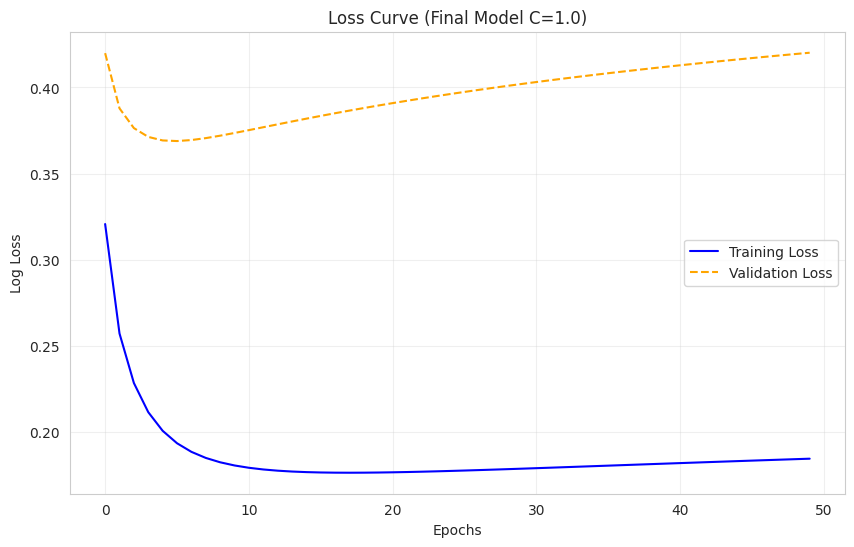

In [33]:

# 1. Decision: Stick with C=1.0
# Our experiments showed that the default C=1.0 (Baseline) gave the highest accuracy (85.07%).
# The tuned values (small C) caused slight underfitting, so we discarded them.

final_c = 1.0
print(f"\n--- Training Learning Curve with Best C={final_c} ---")

# 2. Setup Model for "Step-by-Step" Training
# Normal LogisticRegression finishes training instantly (black box).
# To visualize the learning curve, we use this trick:
# - warm_start=True: "Don't reset what you learned in the previous step."
# - max_iter=1: "Train for just one round, then pause so we can measure accuracy."

model = LogisticRegression(C=final_c, solver='saga', warm_start=True, max_iter=1, random_state=1)

train_loss, test_loss = [], []
epochs = 50

# We temporarily ignore warnings because the model will complain
# "I haven't converged yet!" after every step (which is intentional here).

warnings.filterwarnings('ignore')
print("-" * 60)

for epoch in range(epochs):
    # Train one step
    model.fit(X_train_pca, y_train)

    # Get predictions
    y_prob_tr = model.predict_proba(X_train_pca)
    y_prob_te = model.predict_proba(X_test_pca)
    y_pred_te = model.predict(X_test_pca)

    # Calculate metrics
    loss_tr = log_loss(y_train, y_prob_tr)
    loss_te = log_loss(y_test, y_prob_te)

    acc_tr = accuracy_score(y_train, model.predict(X_train_pca))
    acc_te = accuracy_score(y_test, y_pred_te)

    # Store for plotting
    train_loss.append(loss_tr)
    test_loss.append(loss_te)

 # Print progress in a readable format (similar to Keras/Deep Learning output)

    print(f"Epoch {epoch+1}/{epochs} - loss: {loss_tr:.4f} - acc: {acc_tr:.4f} - val_loss: {loss_te:.4f} - val_acc: {acc_te:.4f}")

print("-" * 60)
warnings.filterwarnings('default')

# 3. Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Validation Loss', color='orange', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title(f'Loss Curve (Final Model C={final_c})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [34]:
# HYPERPARAMETER TUNING ANALYSIS
# ---------------------------------------------------------
# 1. We performed a rigorous Grid Search (Wide -> Fine) to find the optimal 'C'.
#    - Wide Search Range: 10^-4 to 10^4
#    - Fine Search Best Result: C = 0.00023 (Accuracy: ~83.41%)
#
# 2. We compared this against the Baseline Model (C=1.0).
#    - Baseline Result: C = 1.0 (Accuracy: ~85.07%)
#
# 3. CONCLUSION:
#    The Grid Search proved that strong regularization (very small C) caused
#    slight underfitting for our PCA features. The baseline (C=1.0) allows
#    the model to learn better from the compressed features.
#
#    Decision: We select C=1.0 based on empirical evidence (Highest Accuracy).

In [35]:
# We retrain one last time with max_iter=2000 to ensure the model
# reaches its absolute best performance (beyond the 50 epochs of the plot).
model = LogisticRegression(C=1.0, solver='saga', max_iter=2000, random_state=1)
model.fit(X_train_pca, y_train)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


LogisticRegression(max_iter=2000, random_state=1, solver='saga')

In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Get Predictions (Run once, use everywhere)
# y_pred: The final class labels the model chose (e.g., "Glaucoma").
# y_prob: The confidence score for each class (needed for ROC curves).
y_pred = model.predict(X_test_pca)
y_prob = model.predict_proba(X_test_pca)

print("Predictions calculated successfully.")

Predictions calculated successfully.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [37]:
# 1. Overall Accuracy
# This is the main number we care about (e.g., 85%).
acc = accuracy_score(y_test, y_pred)
print(f"Overall Test Accuracy: {acc * 100:.2f}%\n")

# 2. Detailed Report
# Break down performance by disease (Precision/Recall).
# Helps us see if the model is good at one disease but bad at another.
print(classification_report(y_test, y_pred, target_names=class_names))

Overall Test Accuracy: 86.37%

                      precision    recall  f1-score   support

            cataract       0.84      0.82      0.83       208
diabetic_retinopathy       1.00      1.00      1.00       220
            glaucoma       0.80      0.72      0.76       201
              normal       0.81      0.91      0.86       215

            accuracy                           0.86       844
           macro avg       0.86      0.86      0.86       844
        weighted avg       0.86      0.86      0.86       844



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


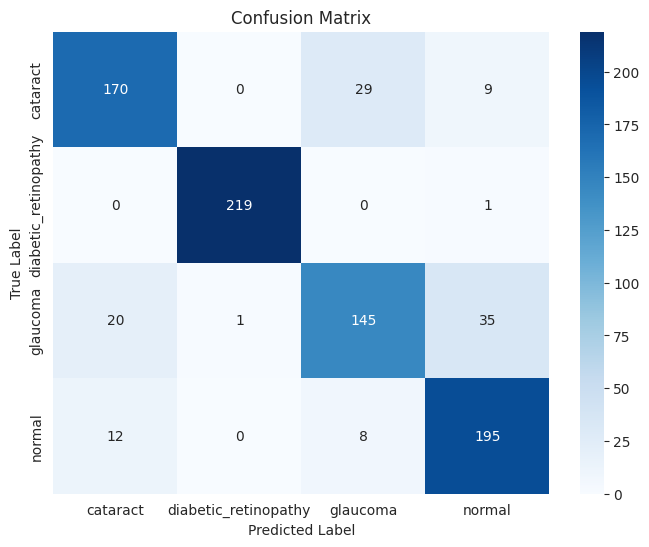

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [38]:
# 1. Create the matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)

# 2. Plot heatmap
# Darker blue on the diagonal is good (correct predictions).
# Any numbers outside the diagonal represent confusion/errors.
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

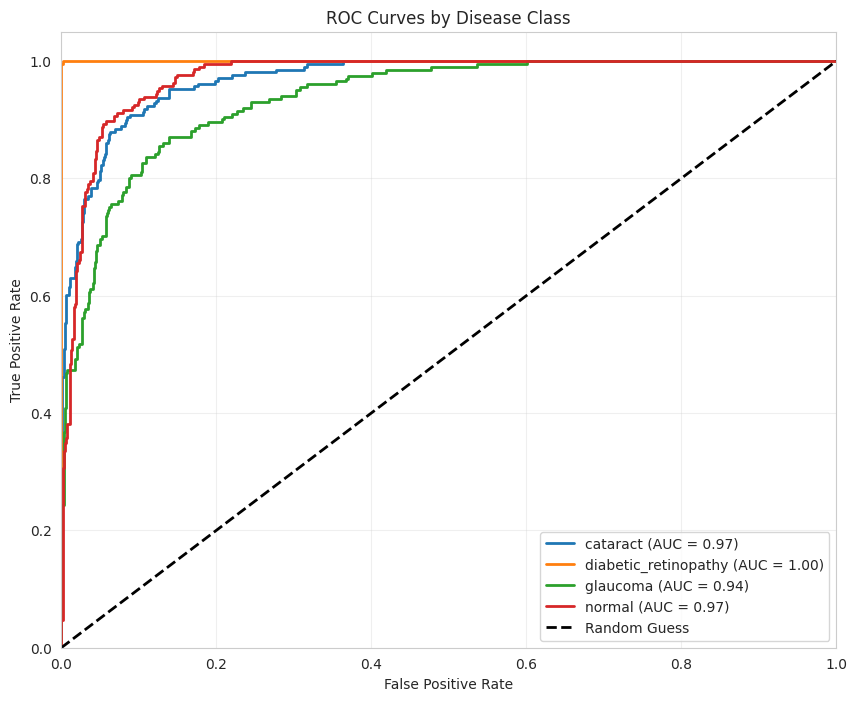

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [39]:
# 1. Prepare data (Binarize labels)
# We need to convert text labels to binary (0/1) to draw these curves.
lb = LabelBinarizer()
lb.fit(y_test)
y_test_bin = lb.transform(y_test)

n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))

# 2. Loop through each disease
for i in range(n_classes):
    # Safety Check: We only plot if there are actual positive samples in the test set.
    # This prevents the "UndefinedMetricWarning" we saw earlier.
    if np.sum(y_test_bin[:, i]) > 0:
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)

        # Get the class name nicely
        label_name = lb.classes_[i] if hasattr(lb, 'classes_') else f"Class {i}"
        plt.plot(fpr, tpr, lw=2, label=f'{label_name} (AUC = {roc_auc:.2f})')

# 3. Add the "Random Guess" line (Diagonal)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Disease Class')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [40]:
# ---------------------------------------------------------
# FINAL DETAILED EVALUATION
# ---------------------------------------------------------
# Why do we need all these graphs?
#
# 1. Accuracy alone is tricky: A model might get 85% accuracy but fail completely
#    to detect a specific disease (like Glaucoma). We need to check that.
#
# 2. Confusion Matrix: Tells us exactly "Where" the model makes mistakes.
#    (e.g., Does it confuse Diabetic Retinopathy with Normal eyes?)
#
# 3. ROC Curves: Shows how "confident" the model is.
#    A perfect model has curves that hug the top-left corner (AUC = 1.0).
# ---------------------------------------------------------

Expected accuracy: 70-80%



---



# **Results Visualization**

K-Means Clustering & Visualization
What happens:

Run K-Means for multiple K values (2-6)

Evaluate clusters using Silhouette Score & Purity

Select best K (highest Silhouette)

Reduce to 2D using t-SNE

Visualize

True labels vs Clusters

See if unsupervised clustering matches diseases

In [46]:
import warnings
warnings.filterwarnings("ignore")

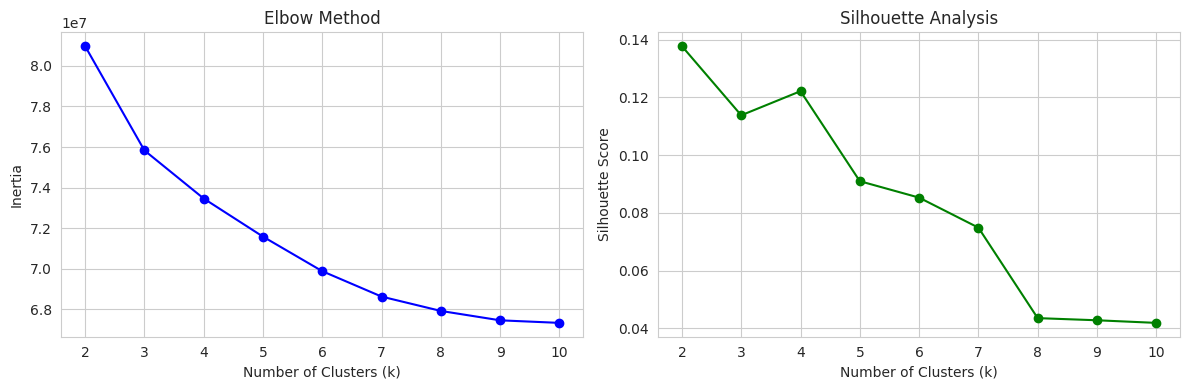

Silhouette Score (Train): 0.1222
Davies-Bouldin Score (Train): 2.5067
Cluster distribution: [ 258 2208  165  742]


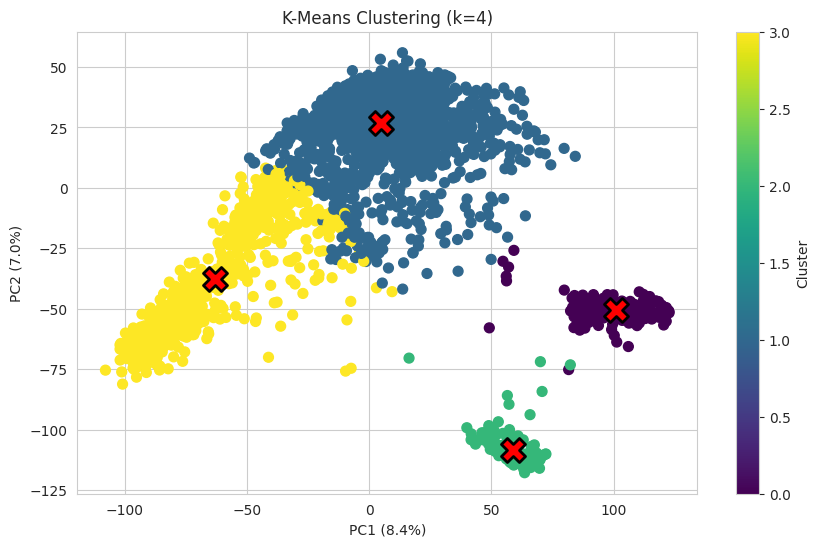

In [47]:
from sklearn.metrics import davies_bouldin_score

# Your data is already PCA-reduced
# Xtrainpca, Xtestpca, ytrain, ytest are already available

# 1. Find optimal number of clusters using Elbow Method
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train_pca, kmeans.labels_))

# 2. Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True)

ax2.plot(k_range, silhouette_scores, 'go-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.grid(True)

plt.tight_layout()
plt.show()

# 3. Train final K-Means (use k=4 since you have 4 diseases)
optimal_k = 4  # Adjust based on elbow plot
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels_train = kmeans_final.fit_predict(X_train_pca)
cluster_labels_test = kmeans_final.predict(X_test_pca)

# 4. Evaluate clustering quality
print(f"Silhouette Score (Train): {silhouette_score(X_train_pca, cluster_labels_train):.4f}")
print(f"Davies-Bouldin Score (Train): {davies_bouldin_score(X_train_pca, cluster_labels_train):.4f}")
print(f"Cluster distribution: {np.bincount(cluster_labels_train)}")

# 5. Visualize clusters using PCA (2D)
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_train_pca)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels_train, cmap='viridis', s=50)
centers_2d = pca_2d.transform(kmeans_final.cluster_centers_)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', marker='X', s=300, edgecolors='black', linewidths=2)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
plt.title(f'K-Means Clustering (k={optimal_k})')
plt.show()

   Train Purity: 0.4560 (45.60%)
   Test Purity:  0.4633 (46.33%)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3373 samples in 0.097s...
[t-SNE] Computed neighbors for 3373 samples in 4.000s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3373
[t-SNE] Computed conditional probabilities for sample 2000 / 3373
[t-SNE] Computed conditional probabilities for sample 3000 / 3373
[t-SNE] Computed conditional probabilities for sample 3373 / 3373
[t-SNE] Mean sigma: 31.708884
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.206673
[t-SNE] KL divergence after 1000 iterations: 1.804218


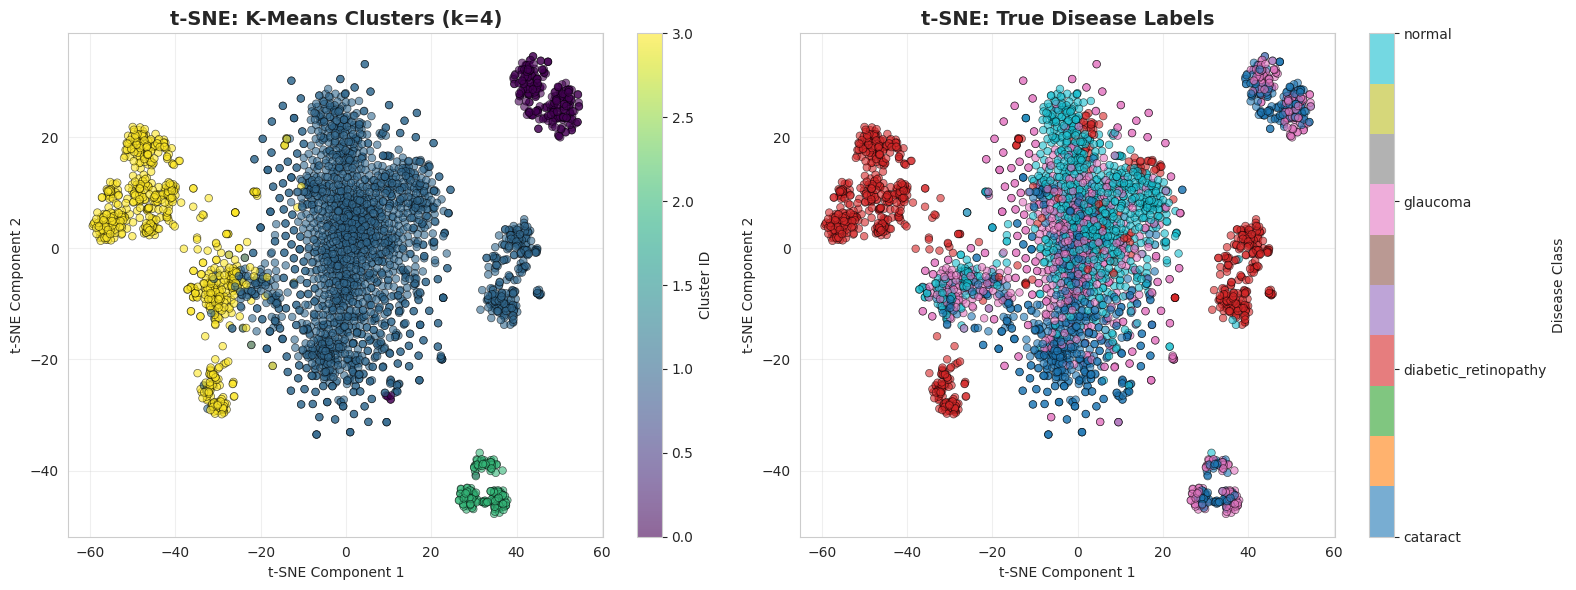

 PER-CLUSTER PURITY:
   Cluster 0: 55.43% purity |  258 samples | Dominant: cataract
   Cluster 1: 34.87% purity | 2208 samples | Dominant: normal
   Cluster 2: 51.52% purity |  165 samples | Dominant: glaucoma
   Cluster 3: 72.78% purity |  742 samples | Dominant: diabetic_retinopathy

 SILHOUETTE ANALYSIS:
   Overall Mean: 0.1222
   Cluster 0: 0.1800
   Cluster 1: 0.1324
   Cluster 2: 0.3005
   Cluster 3: 0.0319


In [48]:
from sklearn.metrics import silhouette_samples
from scipy.optimize import linear_sum_assignment

# 1. Calculate Purity function
def calculate_purity(true_labels, cluster_labels):
    n_samples = len(true_labels)
    n_clusters = len(np.unique(cluster_labels))
    n_classes = len(np.unique(true_labels))

    contingency = np.zeros((n_clusters, n_classes))
    for i in range(n_samples):
        contingency[cluster_labels[i], true_labels[i]] += 1

    # Find best assignment of clusters to classes
    row_ind, col_ind = linear_sum_assignment(-contingency)
    purity = contingency[row_ind, col_ind].sum() / n_samples

    return purity, contingency

# 2. Encode labels
le = LabelEncoder()
ytrain_encoded = le.fit_transform(y_train)
ytest_encoded = le.transform(y_test)
class_names = le.classes_

# 3. Calculate Purity
purity_train, contingency_train = calculate_purity(ytrain_encoded, cluster_labels_train)
purity_test, contingency_test = calculate_purity(ytest_encoded, cluster_labels_test)

print(f"   Train Purity: {purity_train:.4f} ({purity_train*100:.2f}%)")
print(f"   Test Purity:  {purity_test:.4f} ({purity_test*100:.2f}%)")

# 4. Apply t-SNE (warning: this takes 1-2 minutes)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)
X_tsne = tsne.fit_transform(X_train_pca)

# 5. Visualize t-SNE with K-Means clusters vs True labels
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: K-Means clusters
scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels_train,
                           cmap='viridis', s=30, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].set_title('t-SNE: K-Means Clusters (k=4)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster ID')
axes[0].grid(True, alpha=0.3)

# Plot 2: True disease labels
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=ytrain_encoded,
                           cmap='tab10', s=30, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].set_title('t-SNE: True Disease Labels', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
cbar2 = plt.colorbar(scatter2, ax=axes[1], ticks=range(len(class_names)))
cbar2.set_ticklabels(class_names)
cbar2.set_label('Disease Class')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 6. Per-cluster purity
print(f" PER-CLUSTER PURITY:")
for cluster_id in range(len(np.unique(cluster_labels_train))):
    mask = cluster_labels_train == cluster_id
    if mask.sum() > 0:
        cluster_purity = contingency_train[cluster_id].max() / mask.sum()
        dominant_disease = class_names[np.argmax(contingency_train[cluster_id])]
        n_samples = mask.sum()
        print(f"   Cluster {cluster_id}: {cluster_purity*100:.2f}% purity | {n_samples:4d} samples | Dominant: {dominant_disease}")

# 7. Silhouette scores
silhouette_vals = silhouette_samples(X_train_pca, cluster_labels_train)
print(f"\n SILHOUETTE ANALYSIS:")
print(f"   Overall Mean: {silhouette_vals.mean():.4f}")
for cluster_id in range(len(np.unique(cluster_labels_train))):
    mask = cluster_labels_train == cluster_id
    cluster_silhouette = silhouette_vals[mask].mean()
    print(f"   Cluster {cluster_id}: {cluster_silhouette:.4f}")